# Feature Importance Analysis of Induced Seismicity Triggering Mechanism

## Business Problem

#### Context

The production of geothermal steam from hydraulically/naturally fractured reservoirs is a complex process and the production rate and ultimate recovery are influenced by a number of factors. The resource potential and reservoir characteristics are predetermined by nature, drilling and completion enable the extraction of the geothermal resources by providing access, while the day-to-day operations of the operators influence the fluid dynamics and its interaction with the reservoir. In order to achieve the best possible resource recovery outcome, the drilling, completion and day-to-day operational processes must be optimised so that the designed metrics, such as best return on investment and shortest payback time or best resource recovery, can be achieved. 

A widely recognised triggering mechanism for induced earthquakes in geothermal to accommodate permeability for fluid to flow is by fluid injection, which causes pressure build-up on critically stressed faults. In addition to the injection rate, operational parameters such as wellhead pressure, total injection volume, well location, geological and geomechanical characteristics are known to have an influence on induced seismicity. 

In this study, we propose a workflow that uses a knowledge-based and data-driven approach for machine learning modelling to reveal patterns between microseismic and operational reservoir data.

#### Problem Statement

Identifying the relationship between micro-earthquake (MEQ) events induced by operational reservoir parameters is very difficult using data analysis alone due to the large number of variables involved. In order to solve this problem, machine learning methods are needed to represent the pattern of characteristics of the operational reservoir parameters that have an impact on the occurrence of induced seismicity.

#### Goals

The aim is to identify which reservoir operating parameters have the most significant influence on induced seismicity in this particular geothermal field. This approach is intended to help stakeholders formulate strategies for carrying out reservoir injection / stimulation and monitoring.

#### Analytical Approach

We start with missing value evaluation to ensure data quality. We then checking multicollinearity and scaling all numerical features. After that, we apply machine learning modelling using different tree-based models to predict the total number of daily microseismic events. The modelling techniques only limited for tree-based models as we aim to incorporate feature importance analysis. The best selected model is the one with the lowest RMSE and MAE metrics and proceeds to model optimization using either random search or grid search hyperparameter tuning. Finally, the optimized tree-based regression model is used to represent which reservoir operating parameters of multiple injection wells are most important in inducing seismicity. 

#### Metric Evaluation

The evaluation metrics to be used are RMSE and MAE

* A commonly used metric to measure the average difference between predicted and actual values is RMSE (Root Mean Squared Error). It calculates the square root of the average of the squared predicted/actual differences. The RMSE is useful because it penalises larger errors. Lower RMSE indicates better performance of models. The RMSE is used instead of the MSE to suppress values with roots due to squaring by the MSE.

* Another metric that measures the average difference between predicted and actual values is MAE (Mean Absolute Error). It calculates the absolute value of the differences between predicted and actual values and then averages these differences. It is easy to understand and interpret and is less sensitive to outliers than other metrics such as Mean Squared Error (MSE). A lower MAE is an indication of better performance of a machine learning model. The MAE measures the average error across forecasts, and the smaller the error, the closer the model's forecasts to the actuals.

### Libraries Set Up

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import missingno 
%matplotlib inline

#Statistics
from scipy.stats import normaltest

# Machine Learning Pre-processing Modules

from scipy.stats import normaltest
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import preprocessing

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV,GridSearchCV,KFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Machine Learning Modeling Modules
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Save model
import pickle

## Data Loading

In [2]:
# Membaca data dari file Excel
df = pd.read_excel('Data MEQ and Reservoir Jan 2021 - May 2023.xlsx') 
df

,date,Injection Rate ML B1 (l/s),Injection Rate ML C1 (l/s),Injection Rate ML D1 (l/s),Injection Rate ML D2 (l/s),Injection Rate ML E1 (l/s),Injection Rate ML E2 (l/s),WHP ML B1 (barg),WHP ML C1 (barg),WHP ML D1 (barg),...,Injection Temperature ML D2(Degree C),Injection Temperature ML E1(Degree C),FCV Opening ML B1 (%),FCV Opening ML D2 (%),FCV Opening ML E1 (%),total_meq_events,cum_sum_meq_event,year,month,day
0,2021-01-01,39.33,0.0,0.0,95.4,91.0,40.0,2.29,0.0,-0.71,...,144.7,198.1,8.0,22.7,17.7,0,635,2021,1,1
1,2021-01-02,39.33,0.0,0.0,96.0,91.0,40.0,2.35,0.0,-0.69,...,144.6,198.0,8.0,22.7,17.7,1,636,2021,1,2
2,2021-01-03,39.87,0.0,0.0,95.4,94.0,40.0,3.03,0.0,-0.68,...,144.7,197.9,7.8,22.7,17.7,0,636,2021,1,3
3,2021-01-04,37.57,0.0,0.0,93.4,94.0,40.0,2.59,0.0,-0.66,...,144.8,198.1,7.5,22.7,17.7,0,636,2021,1,4
4,2021-01-05,41.78,0.0,0.0,75.1,93.0,40.0,4.10,0.0,-0.65,...,146.3,198.0,12.0,22.7,17.7,7,643,2021,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,2023-05-23,38.24,1.6,0.0,177.8,113.0,0.0,3.83,9.0,-0.76,...,148.6,194.9,17.9,33.0,21.7,0,1139,2023,5,23
760,2023-05-24,38.26,1.1,0.0,125.3,112.0,0.0,3.81,9.0,-0.76,...,145.9,194.8,18.0,33.0,21.7,0,1139,2023,5,24
761,2023-05-25,34.77,1.2,0.0,177.0,113.0,0.0,2.83,9.0,-0.77,...,148.6,194.9,15.9,33.0,21.7,2,1141,2023,5,25
762,2023-05-26,35.48,1.4,0.0,177.9,112.0,0.0,2.82,9.0,-0.76,...,148.5,194.9,16.0,33.0,21.7,0,1141,2023,5,26


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   date                                   764 non-null    datetime64[ns]
 1   Injection Rate ML B1 (l/s)             764 non-null    float64       
 2   Injection Rate ML C1 (l/s)             764 non-null    float64       
 3   Injection Rate ML D1 (l/s)             764 non-null    float64       
 4   Injection Rate ML D2 (l/s)             764 non-null    float64       
 5   Injection Rate ML E1 (l/s)             764 non-null    float64       
 6   Injection Rate ML E2 (l/s)             764 non-null    float64       
 7   WHP ML B1 (barg)                       764 non-null    float64       
 8   WHP ML C1 (barg)                       764 non-null    float64       
 9   WHP ML D1 (barg)                       764 non-null    float64   

In [4]:
df.columns

Index(['date', 'Injection Rate ML B1 (l/s)', 'Injection Rate ML C1 (l/s)',
       'Injection Rate ML D1 (l/s)', 'Injection Rate ML D2 (l/s)',
       'Injection Rate ML E1 (l/s)', 'Injection Rate ML E2 (l/s)',
       'WHP ML B1 (barg)', 'WHP ML C1 (barg)', 'WHP ML D1 (barg)',
       'WHP ML D2 (barg)', 'WHP ML E1 (barg)', 'WHP ML E2 (barg)',
       'Injection Temperature ML B1(Degree C)',
       'Injection Temperature ML D2(Degree C)',
       'Injection Temperature ML E1(Degree C)', 'FCV Opening ML B1 (%)',
       'FCV Opening ML D2 (%)', 'FCV Opening ML E1 (%)', 'total_meq_events',
       'cum_sum_meq_event', 'year', 'month', 'day'],
      dtype='object')

# Data Understanding

- `date`: Date of injection activity 
- `Injection Rate`: fluid injection rate in units (l/s)
- `WHP`: wellhead pressure in units (barg)
- `Injection Temperature`: unit of fluid injection temperature (degrees C)
- `FCV`: flow control valves in %.
- `total_meq_events`: number of micro-earthquake events on a given day
- `cum_sum_meq_event`: cumulative sum micro-earthquake events on a given day
- `year`: Year in which a microseismic event was recorded
- `month`: Month in which a microseismic event was recorded
- `day`: Day in which a microseismic event was recorded 

# Preprocessing

#### Missing Value Identification

We need to consider the occurrence of missing values in the first place in order to obtain a clean dataset. To generally identify the missing value and its proportion, we provide a visualisation below.

<Axes: >

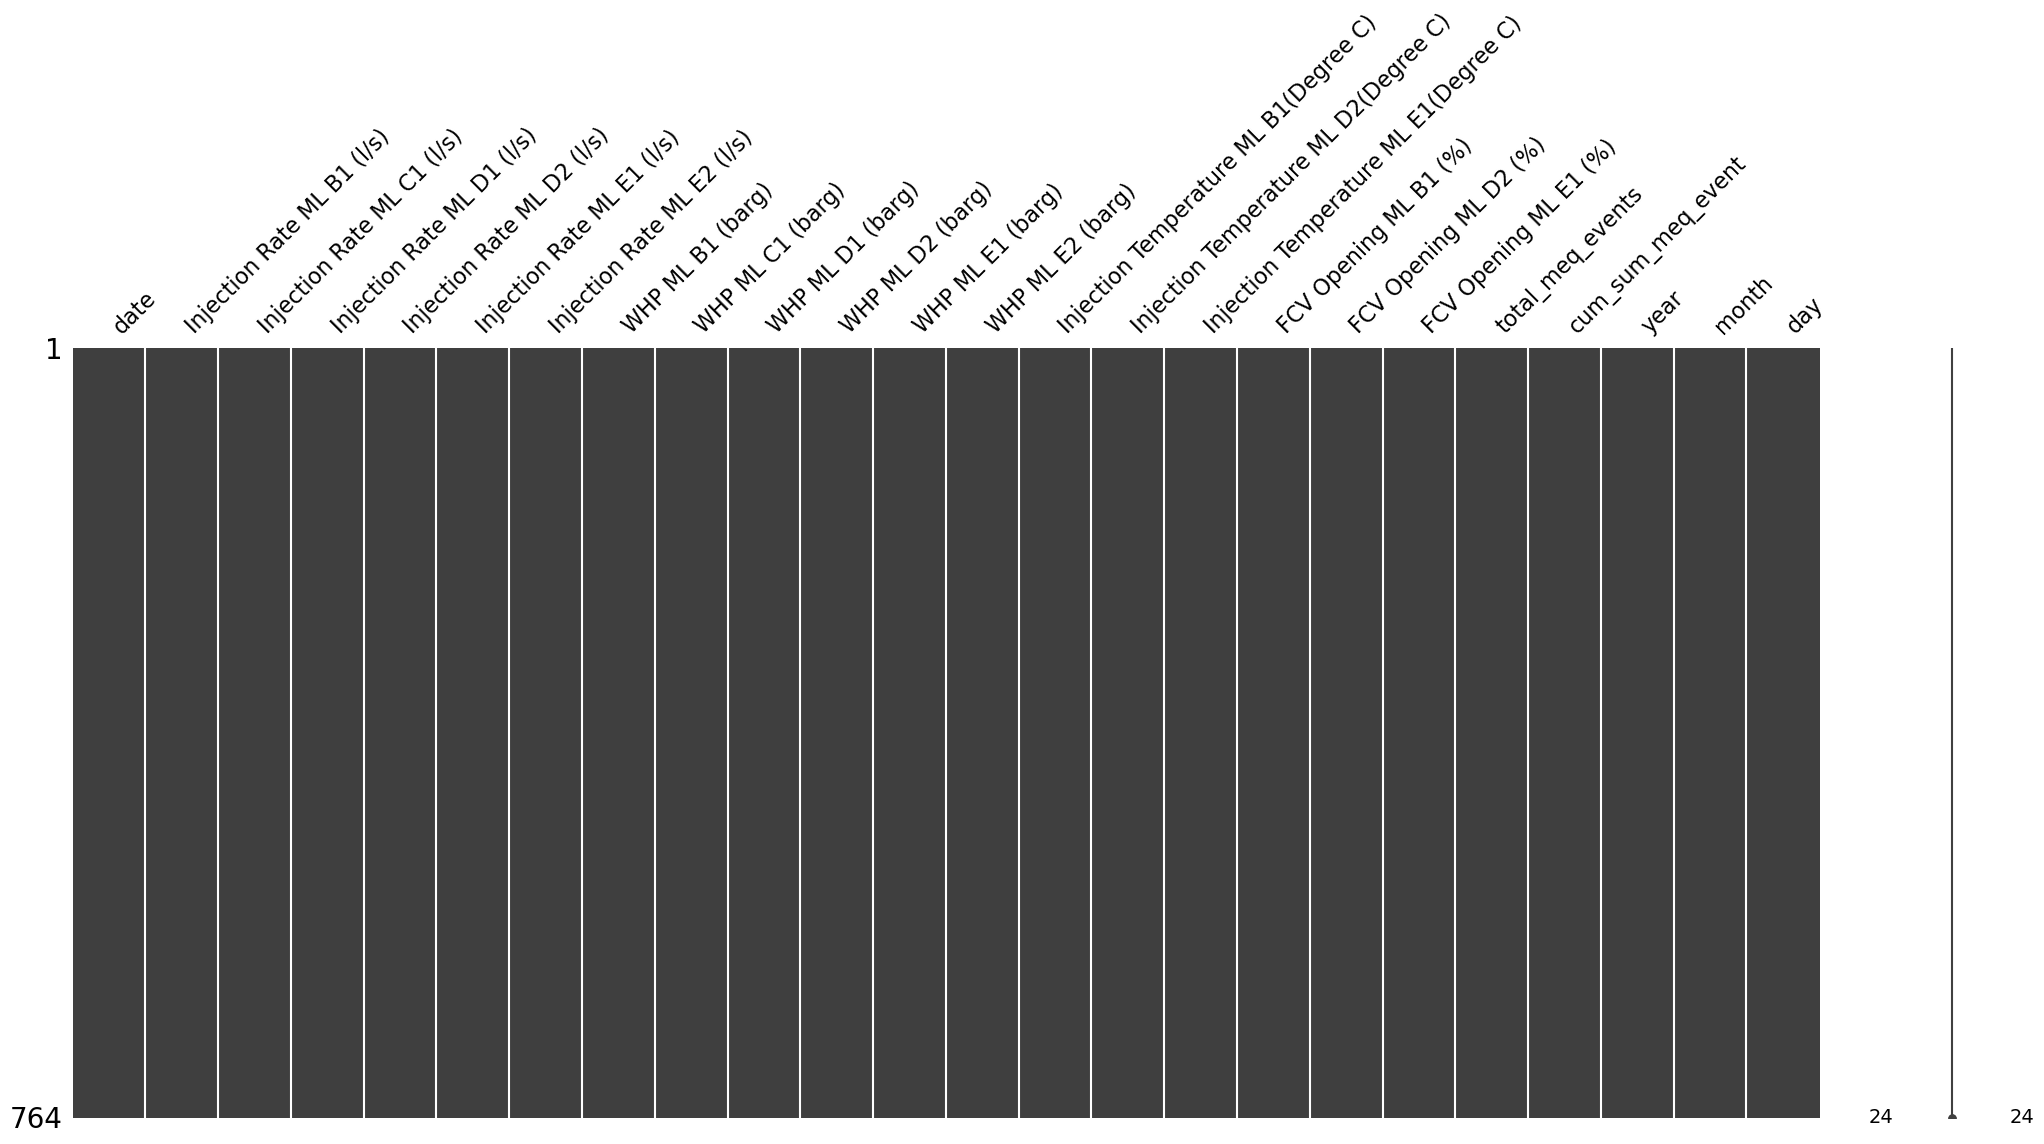

In [5]:
missingno.matrix(df)

As we can see there is no occurence of missing value, so there will be no more treatment regarding missing value in this dataset.

#### Feature Engineering and Multicollinearity Evaluation

Since fluid injection from the reservoir occurs over time, the injection rate feature for each injection well can be made into a new feature that represents the cumulative injection rate. We also provide a correlation map of the features to evaluate multicollinearity between features. Features whose correlation value is above 0.85 or below -0.85 will be considered to indicate multicollinearity or in other words these features are redundant. Feature multicollinearity is reduced by removing redundant features.

In [6]:
df['Cum Sum Injection Rate ML B1 (l/s)'] = df['Injection Rate ML B1 (l/s)'].cumsum()
df['Cum Sum Injection Rate ML C1 (l/s)'] = df['Injection Rate ML C1 (l/s)'].cumsum()
df['Cum Sum Injection Rate ML D1 (l/s)'] = df['Injection Rate ML D1 (l/s)'].cumsum()
df['Cum Sum Injection Rate ML D2 (l/s)'] = df['Injection Rate ML D2 (l/s)'].cumsum()
df['Cum Sum Injection Rate ML E1 (l/s)'] = df['Injection Rate ML E1 (l/s)'].cumsum()
df['Cum Sum Injection Rate ML E2 (l/s)'] = df['Injection Rate ML E2 (l/s)'].cumsum()

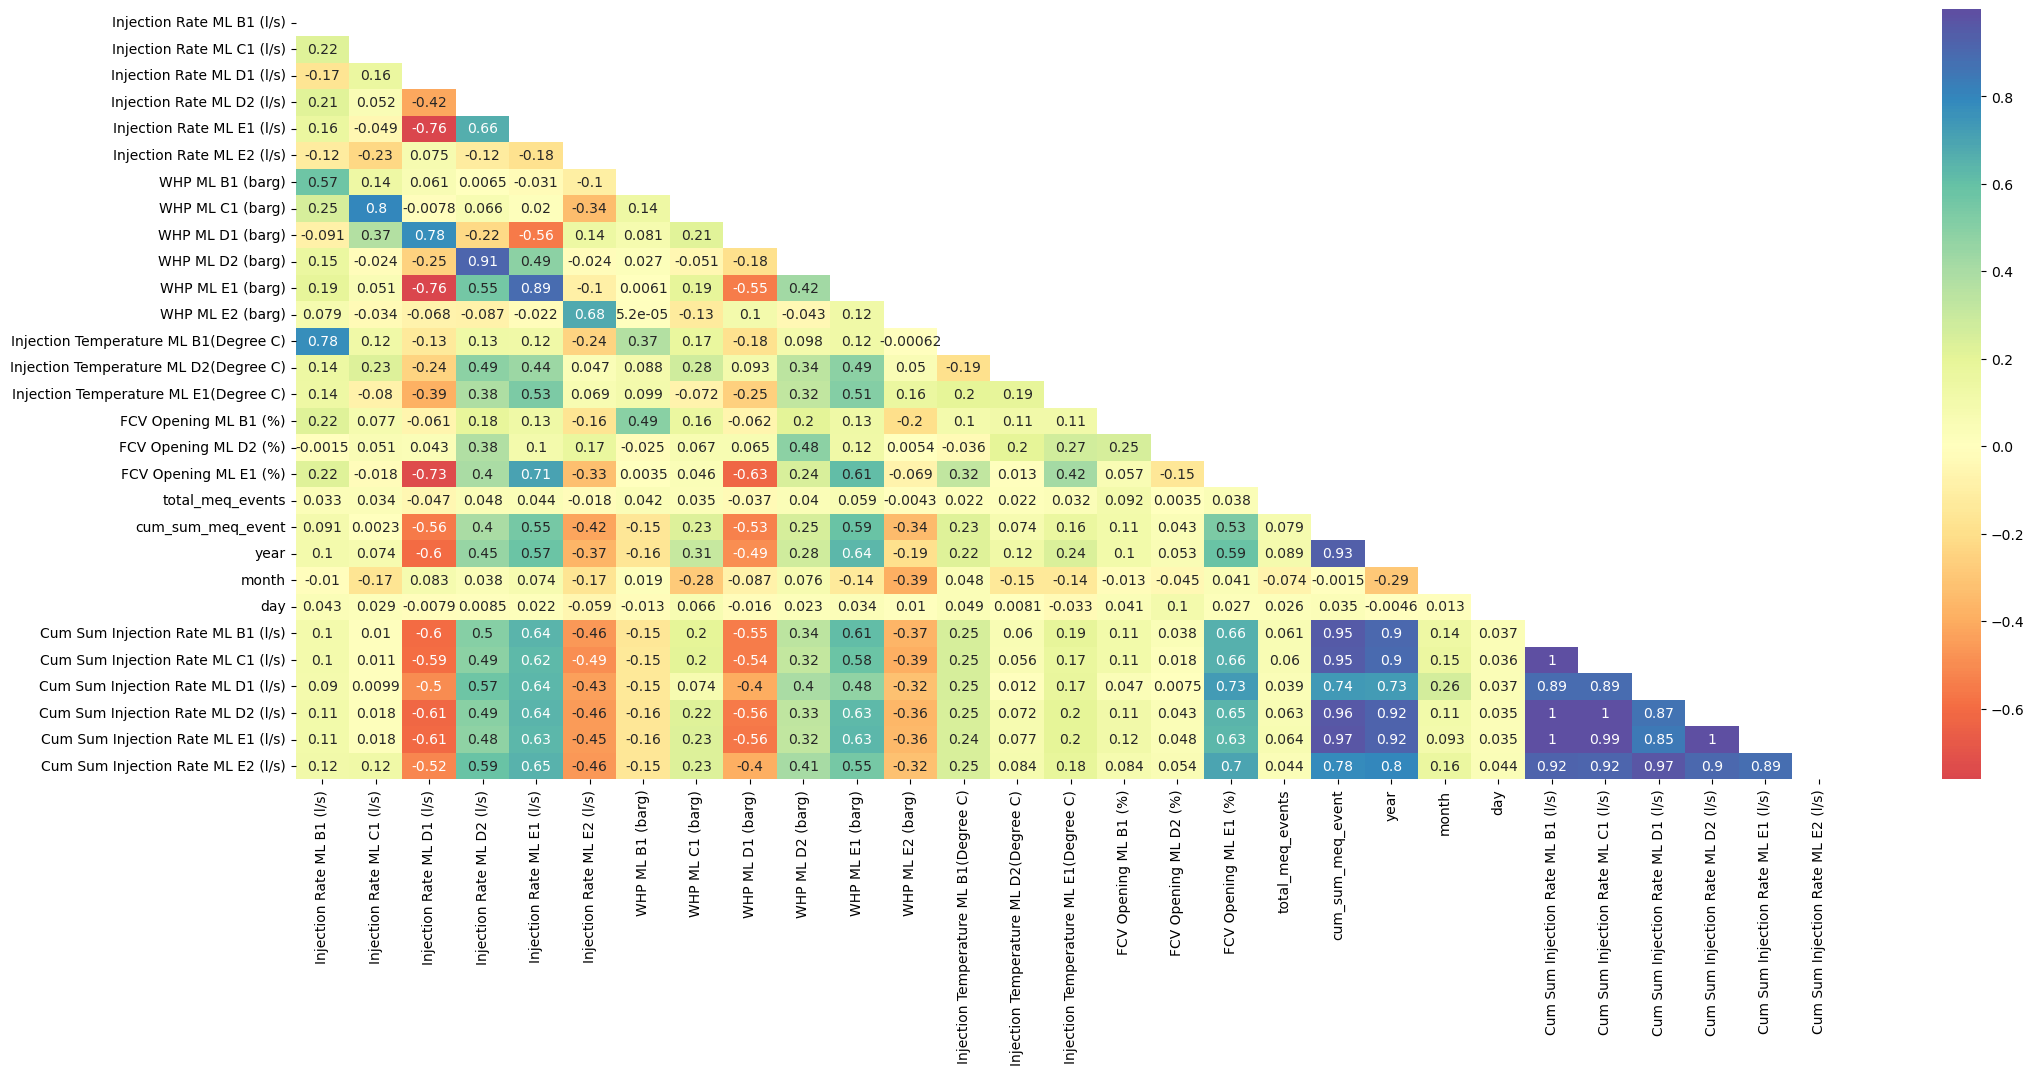

In [7]:
corrmat = df.corr(method='pearson')

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corrmat, dtype=bool))

plt.figure(figsize=(25,10))
sns.heatmap(corrmat, annot=True, cmap='Spectral', center=0, mask=mask)
plt.show()

It turns out that the feature `WHP ML D2 (barg)` has multicollinearity with `Injection Rate ML D2 (l/s)`, the same happens with `WHP ML E1 (barg)` and `Injection Rate ML E1 (l/s)`, so `WHP ML D2 (barg)` and `WHP ML E1 (barg)` will be dropped. Moreover, the features that have multicollinearity with various other features are the `year` and `cum_sum_meq_event`, therefore these two features will be exterminated. Furthermore, it turns out that the addition of cumulative injection rate features from ML well B1, C1, D1, D2, E1, and E2 indicates strong multicollinearity, thus `Cum Sum Injection Rate ML D1 (l/s)` and `Cum Sum Injection Rate ML E1 (l/s)` will be included because the correlation value is the lowest and still limited to 0.85. The `month` and `day` features will also be dropped because the analysis of importance features will only focus on operational reservoir parameters. 

In [8]:
df_model = df.drop(columns=['WHP ML D2 (barg)','WHP ML E1 (barg)','date','cum_sum_meq_event','year','month','day',
                           'Cum Sum Injection Rate ML B1 (l/s)','Cum Sum Injection Rate ML C1 (l/s)',
                           'Cum Sum Injection Rate ML D2 (l/s)','Cum Sum Injection Rate ML E2 (l/s)'], axis=1)

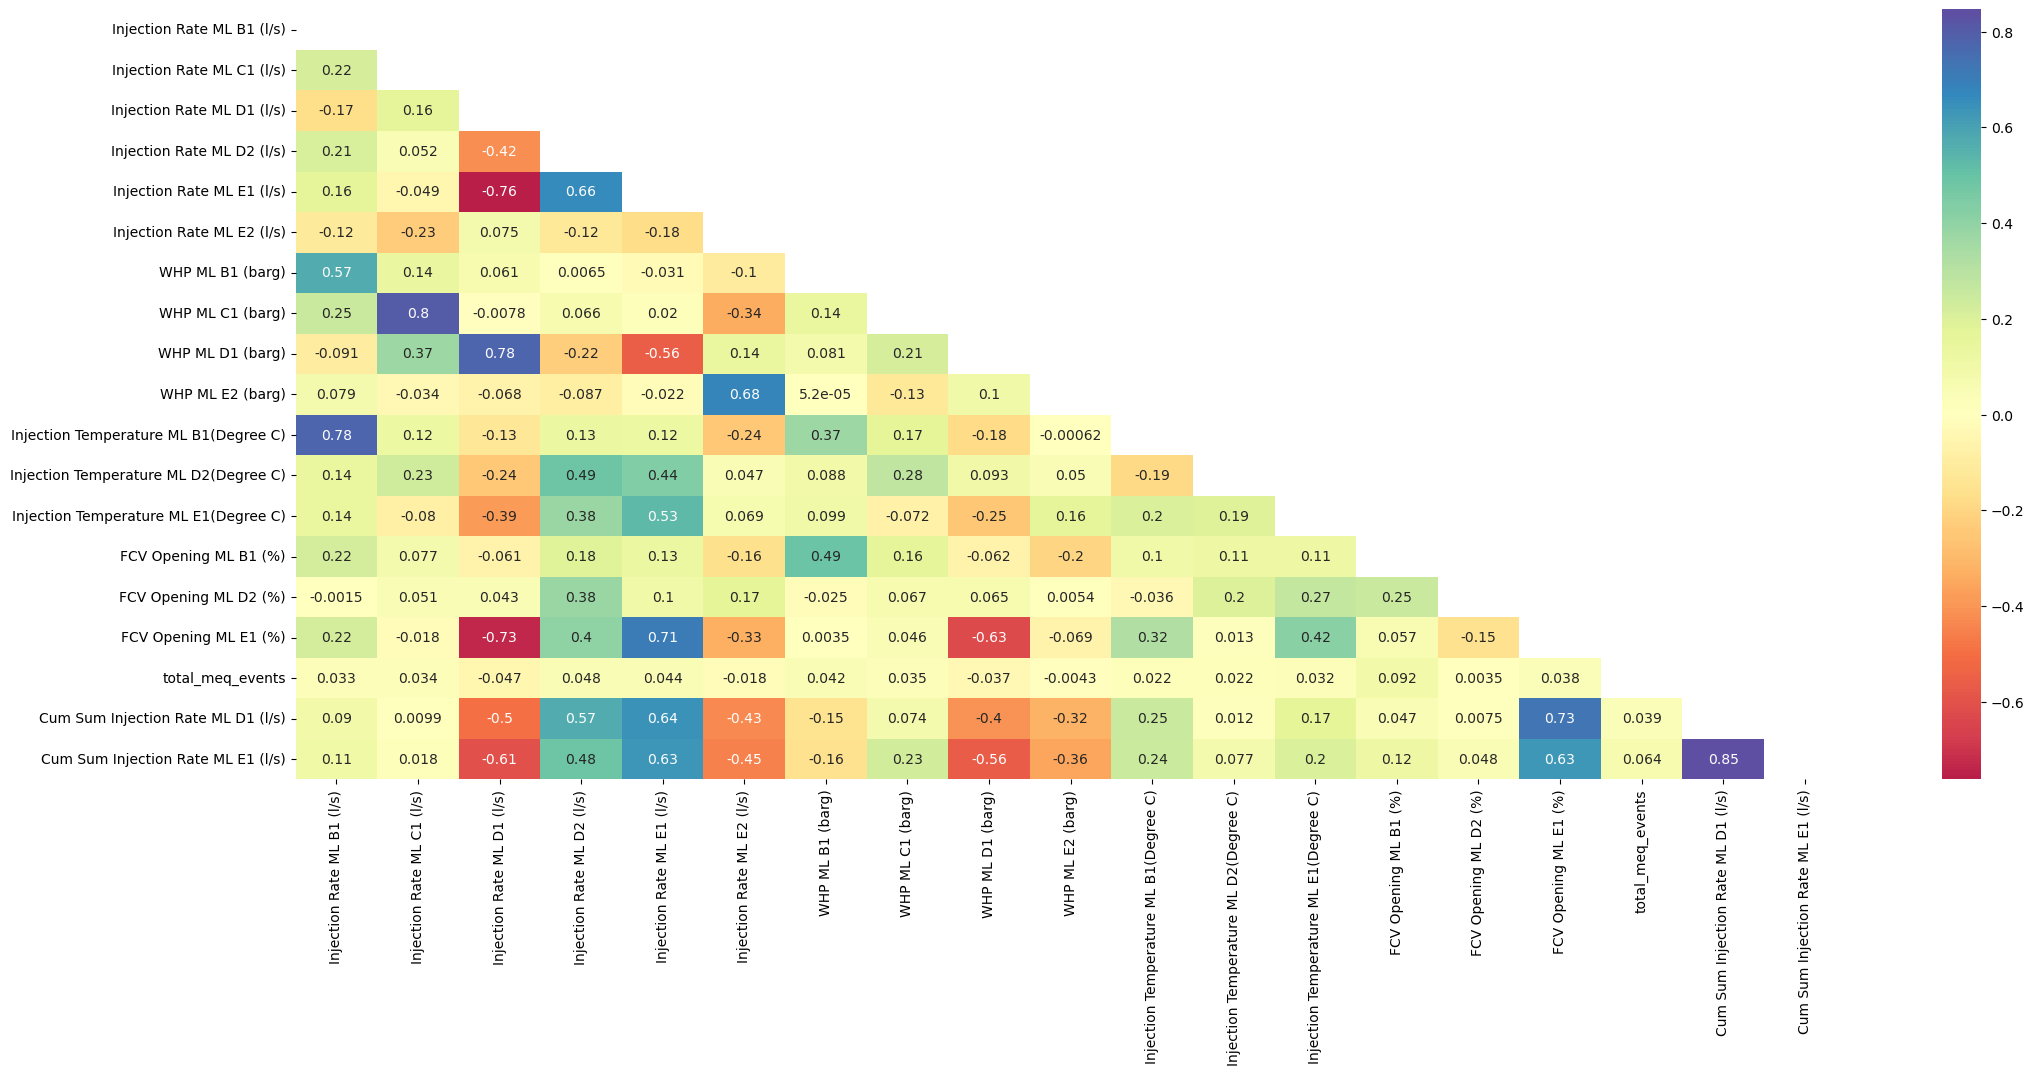

In [9]:
corrmat = df_model.corr(method='pearson')

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corrmat, dtype=bool))

plt.figure(figsize=(25,10))
sns.heatmap(corrmat, annot=True, cmap='Spectral', center=0, mask=mask)
plt.show()

In [10]:
df_model.columns

Index(['Injection Rate ML B1 (l/s)', 'Injection Rate ML C1 (l/s)',
       'Injection Rate ML D1 (l/s)', 'Injection Rate ML D2 (l/s)',
       'Injection Rate ML E1 (l/s)', 'Injection Rate ML E2 (l/s)',
       'WHP ML B1 (barg)', 'WHP ML C1 (barg)', 'WHP ML D1 (barg)',
       'WHP ML E2 (barg)', 'Injection Temperature ML B1(Degree C)',
       'Injection Temperature ML D2(Degree C)',
       'Injection Temperature ML E1(Degree C)', 'FCV Opening ML B1 (%)',
       'FCV Opening ML D2 (%)', 'FCV Opening ML E1 (%)', 'total_meq_events',
       'Cum Sum Injection Rate ML D1 (l/s)',
       'Cum Sum Injection Rate ML E1 (l/s)'],
      dtype='object')

#### Scaling Numerical Features

We can see from the following histogram plot that the data distribution of the numerical features has different scales, so scaling is necessary. From testing various scaling methods such as using MinMax, Robust, and Standard scaling, it turns out that scaling using the MinMaxScaling function is more effective in producing the smallest RMSE and MAE in the benchmarking model process. Therefore, the scaling process applied to this dataset is using MinMaxScaling.

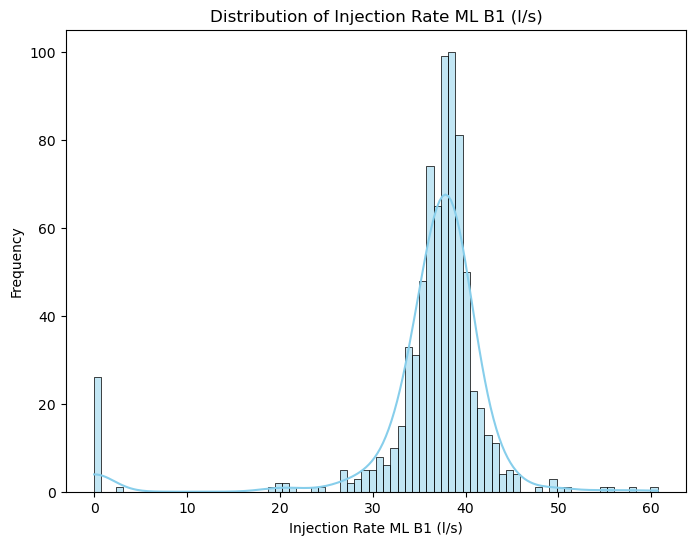

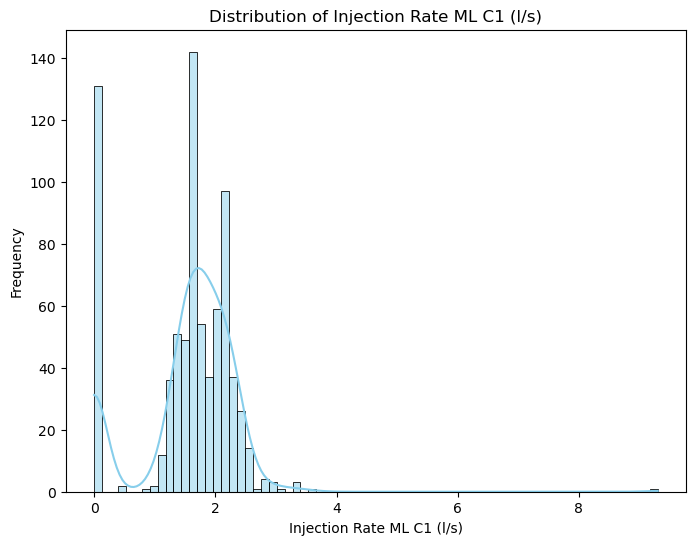

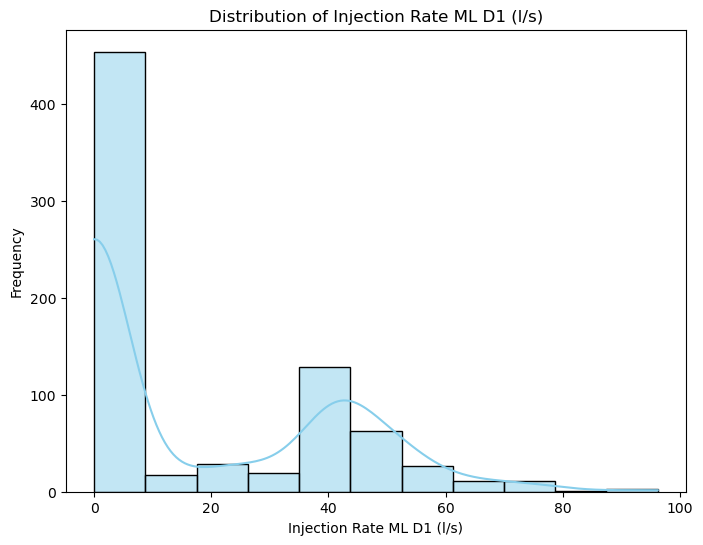

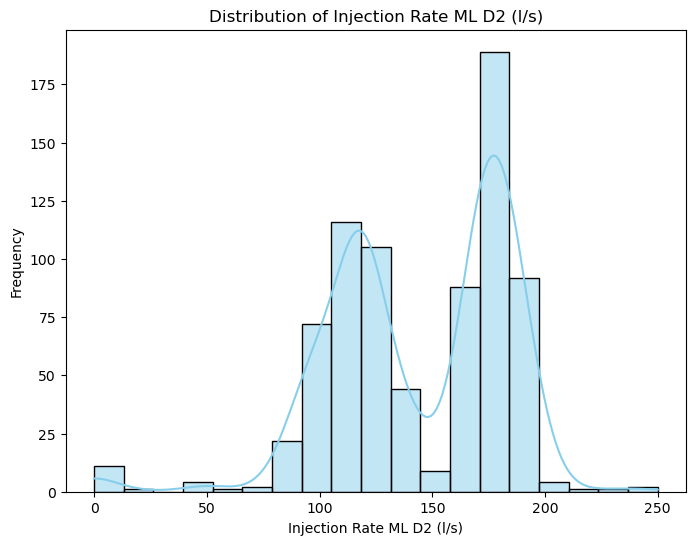

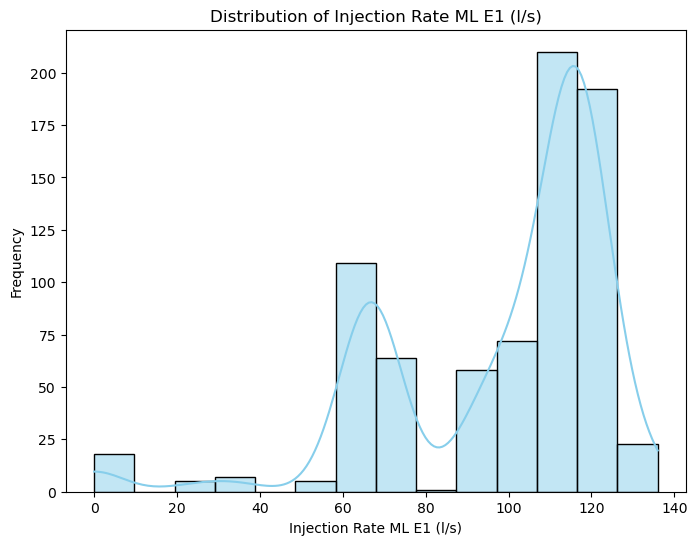

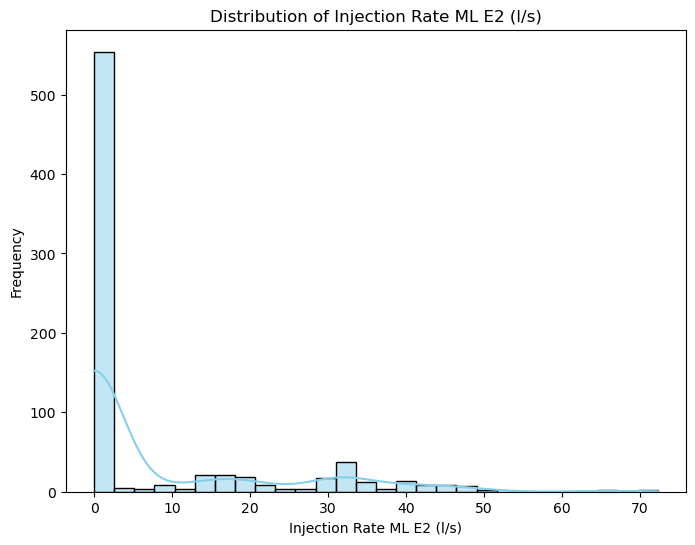

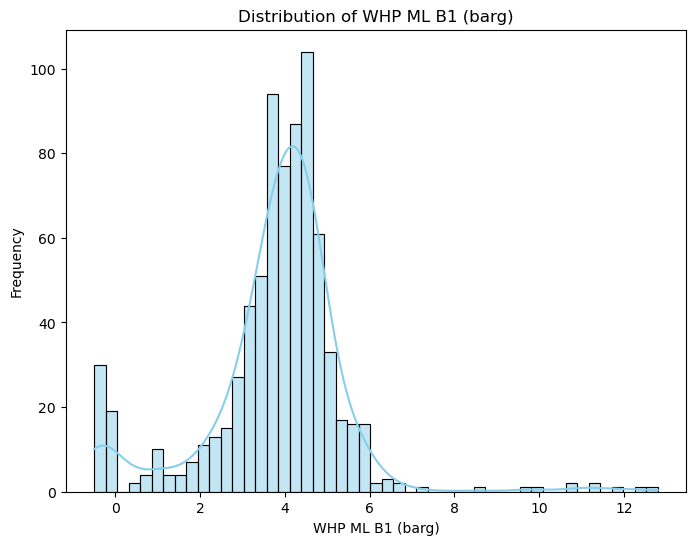

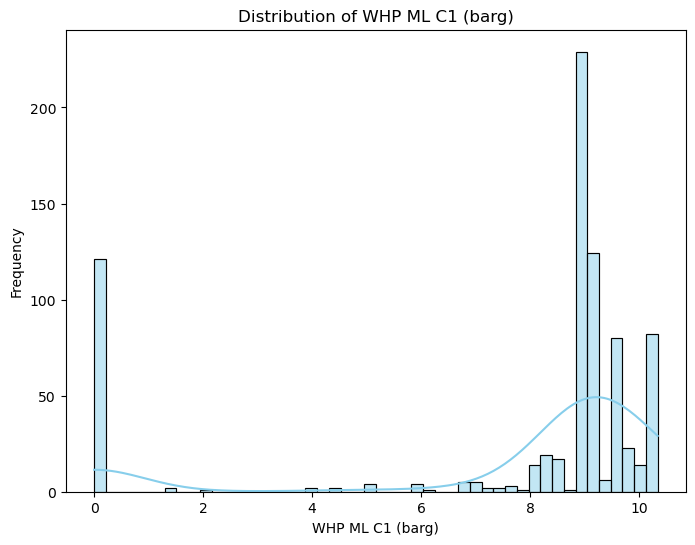

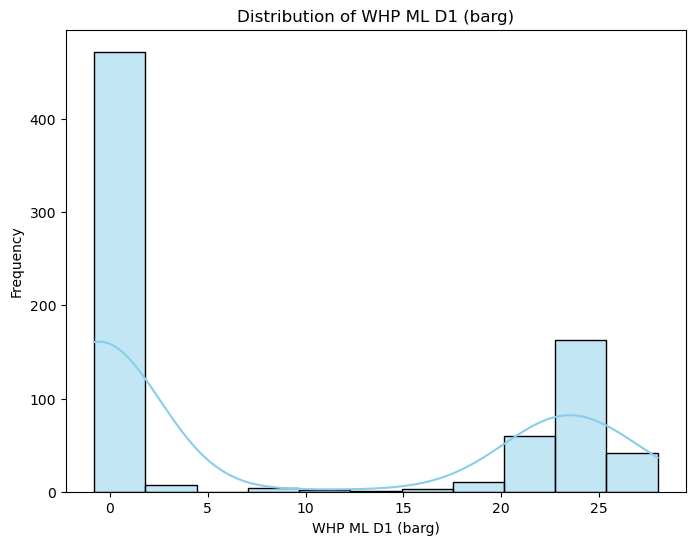

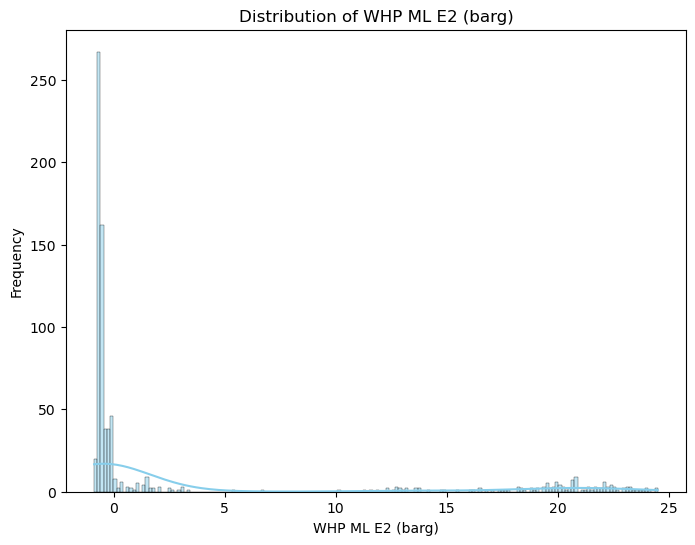

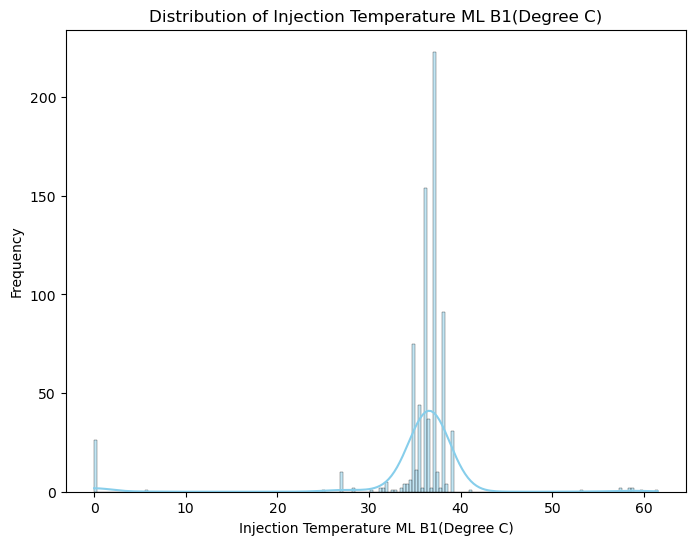

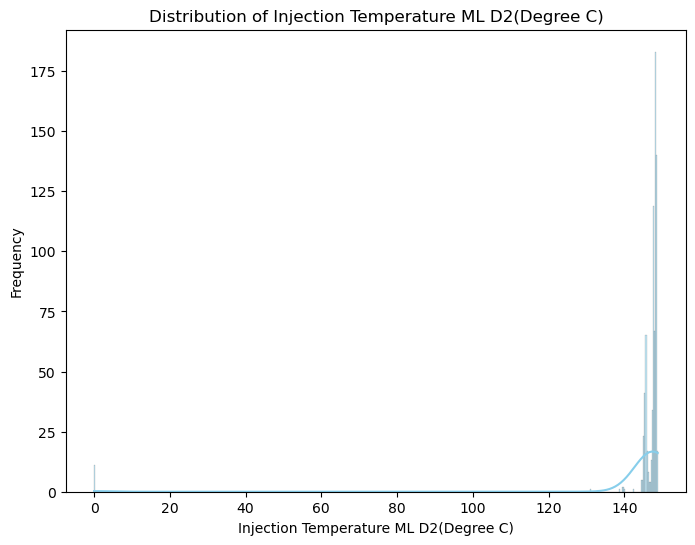

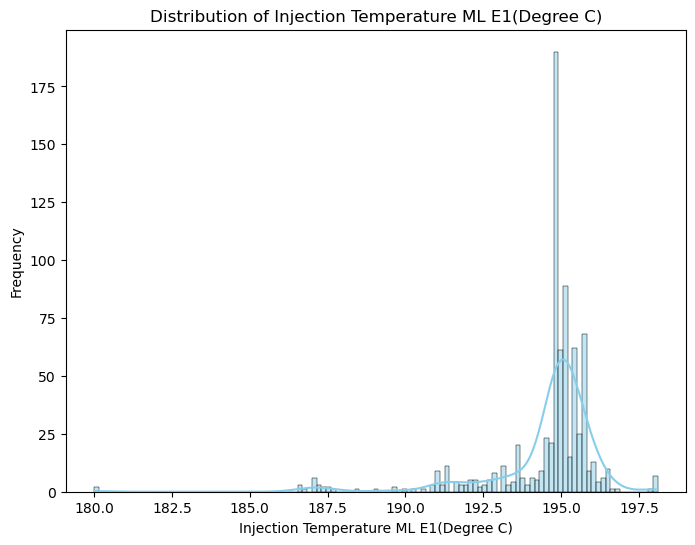

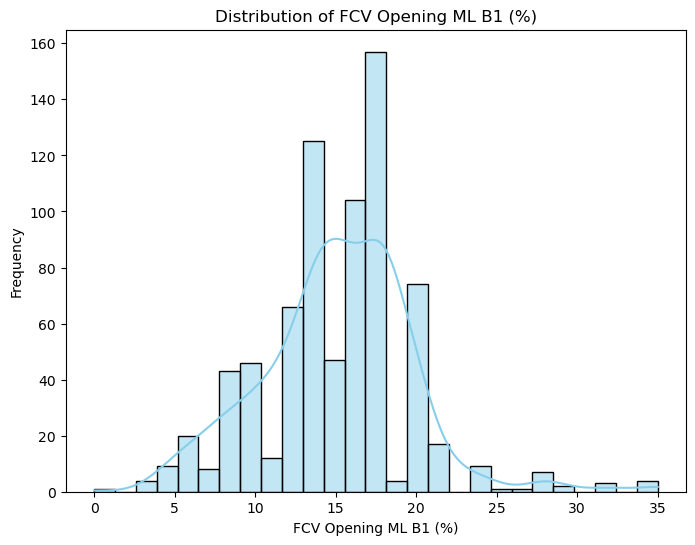

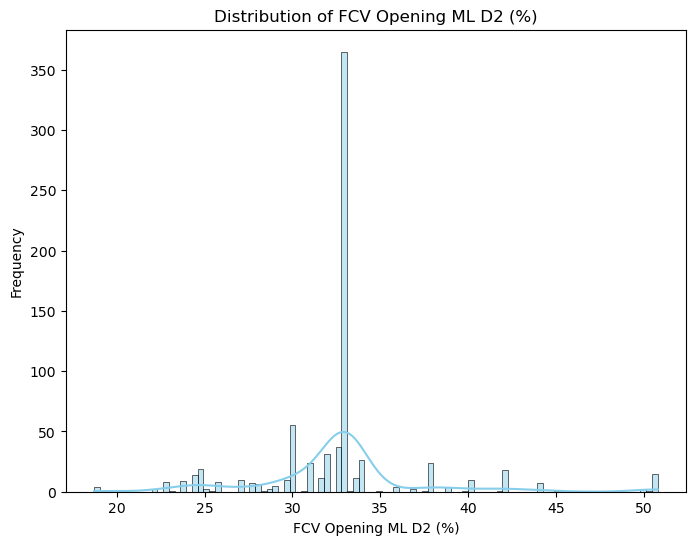

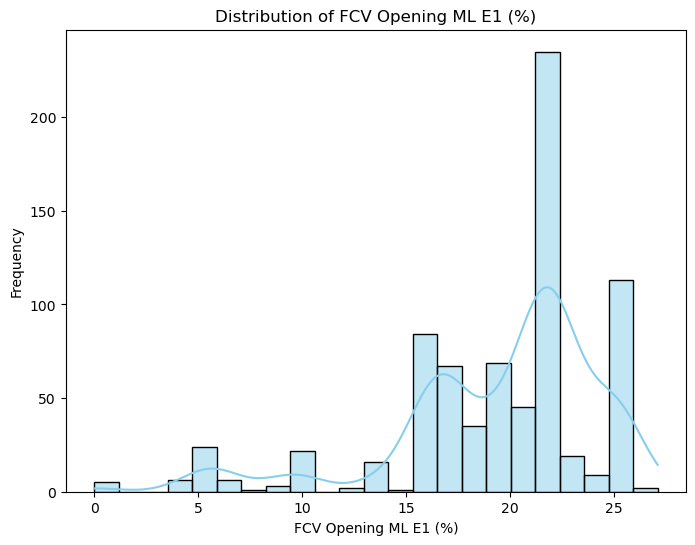

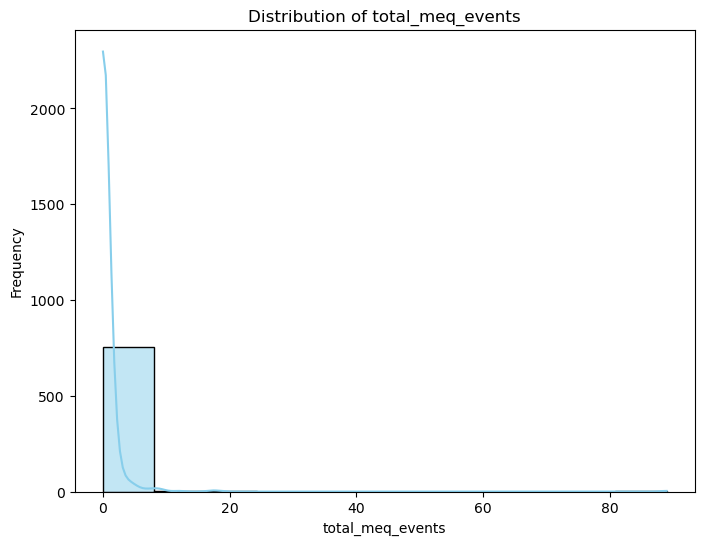

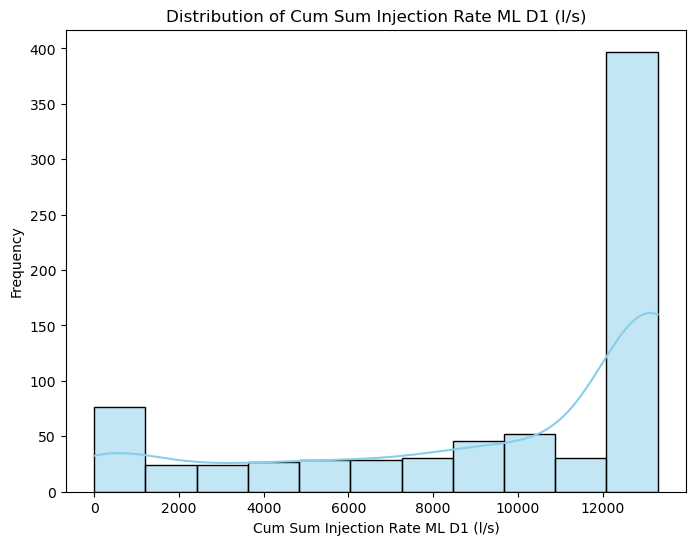

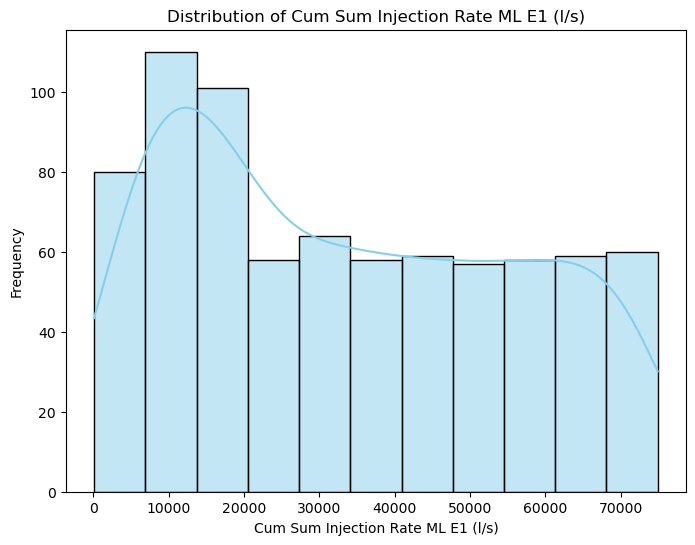

In [11]:
numeric_columns = df_model.select_dtypes(include=['float64', 'int64']).columns

for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[column], kde=True, color='skyblue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [12]:
scaler = preprocessing.MinMaxScaler()

In [13]:
d = scaler.fit_transform(df_model)
scaled_df = pd.DataFrame(d, columns=df_model.columns)
print(scaled_df)

     Injection Rate ML B1 (l/s)  Injection Rate ML C1 (l/s)  \
0                      0.647941                    0.000000   
1                      0.647941                    0.000000   
2                      0.656837                    0.000000   
3                      0.618946                    0.000000   
4                      0.688303                    0.000000   
..                          ...                         ...   
759                    0.629984                    0.172043   
760                    0.630313                    0.118280   
761                    0.572817                    0.129032   
762                    0.584514                    0.150538   
763                    0.619440                    0.161290   

     Injection Rate ML D1 (l/s)  Injection Rate ML D2 (l/s)  \
0                           0.0                      0.3816   
1                           0.0                      0.3840   
2                           0.0                      0

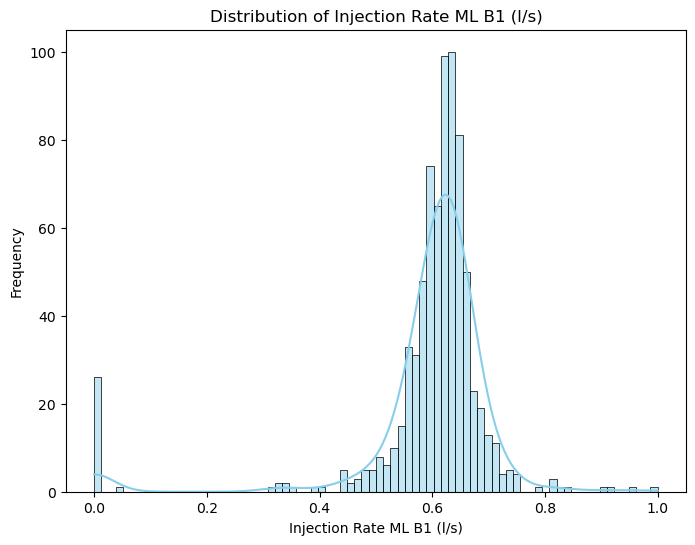

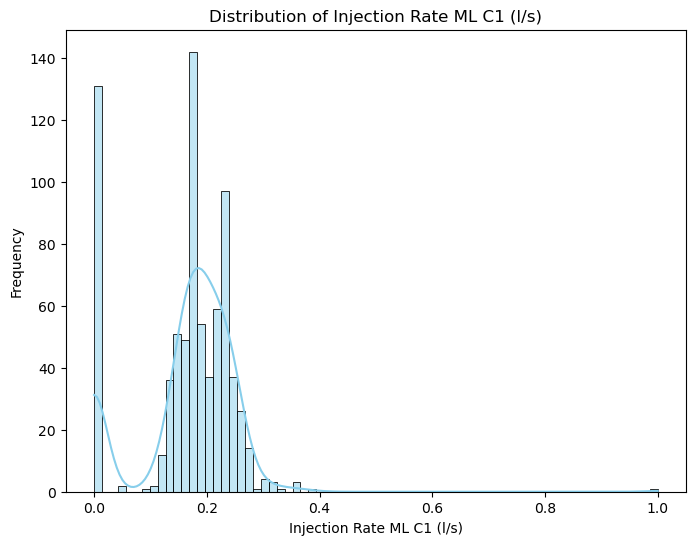

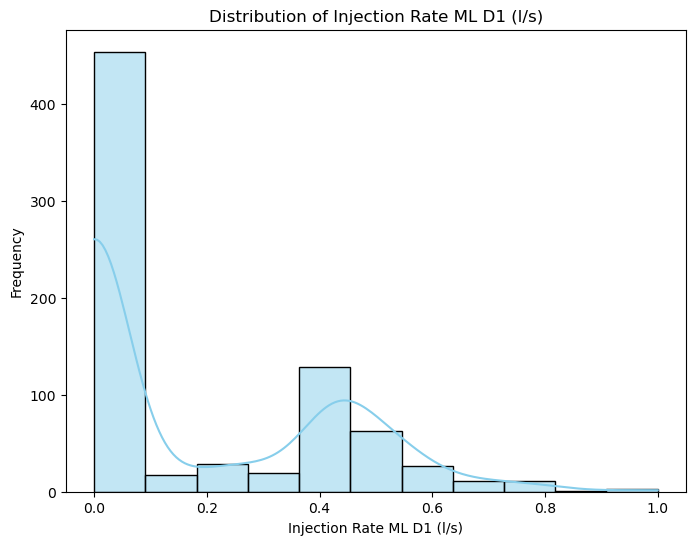

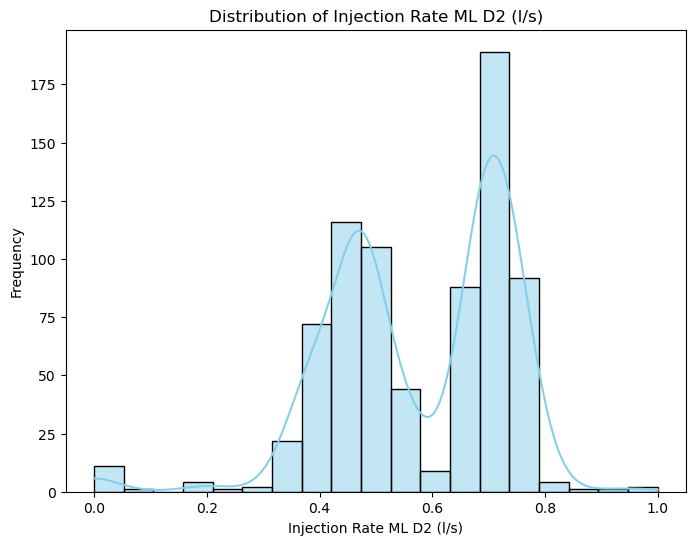

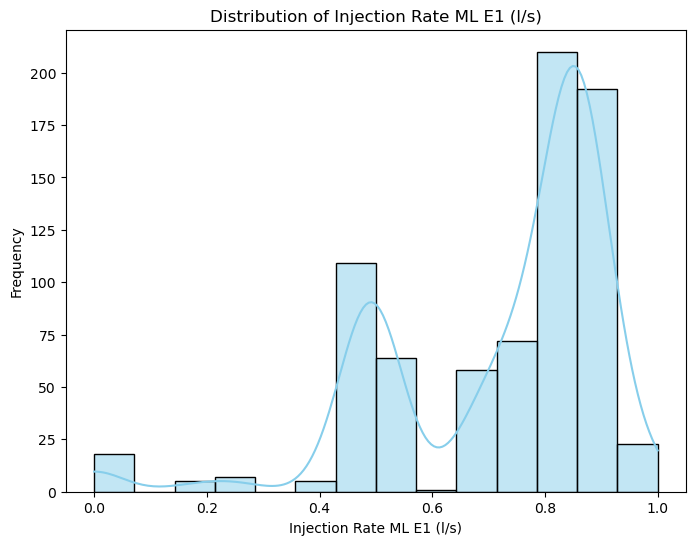

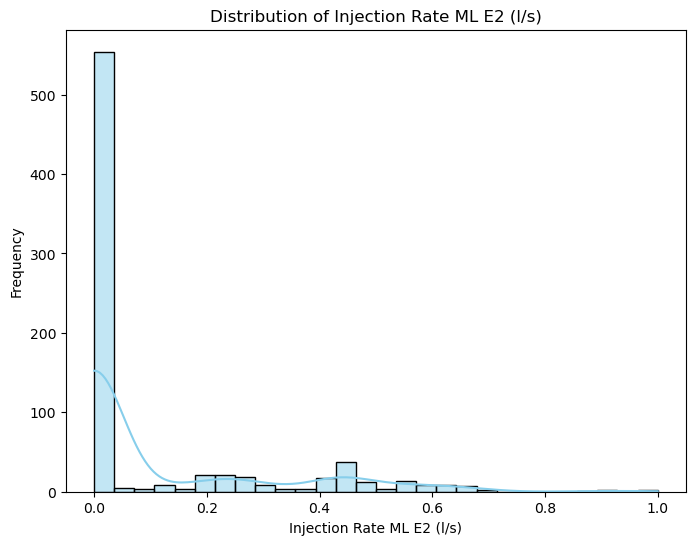

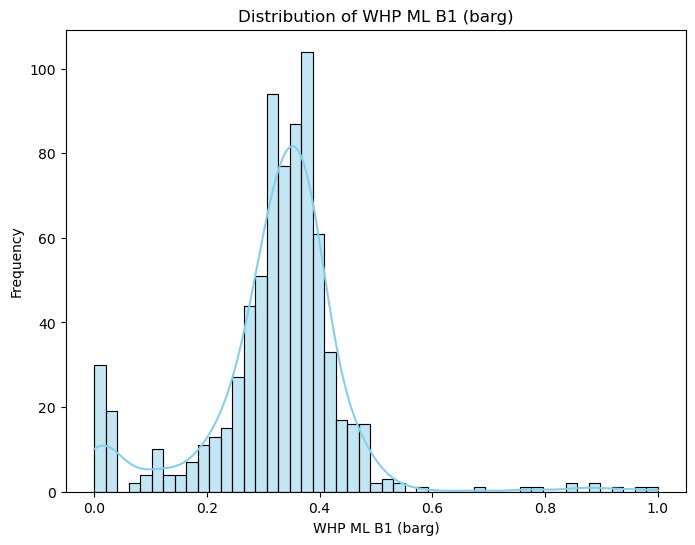

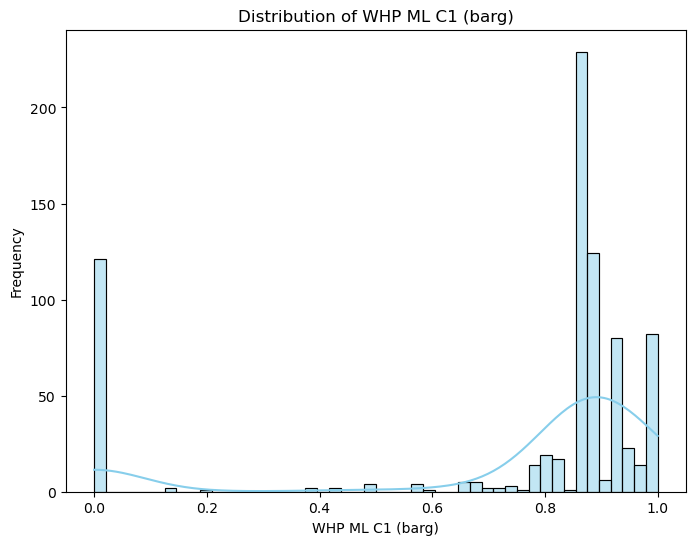

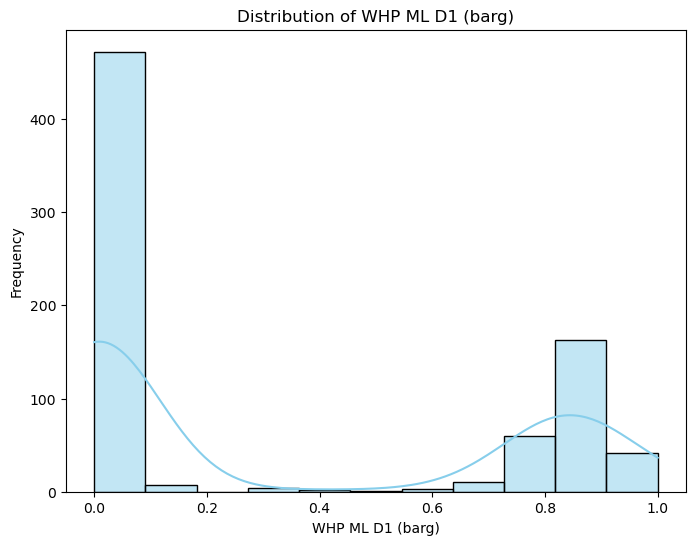

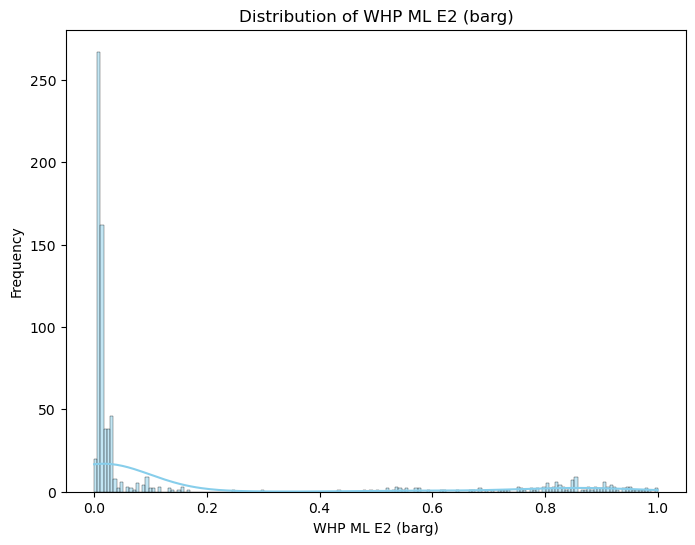

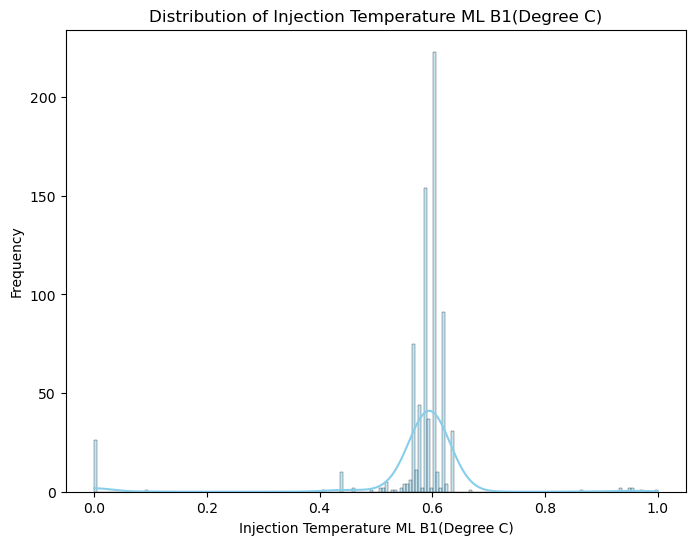

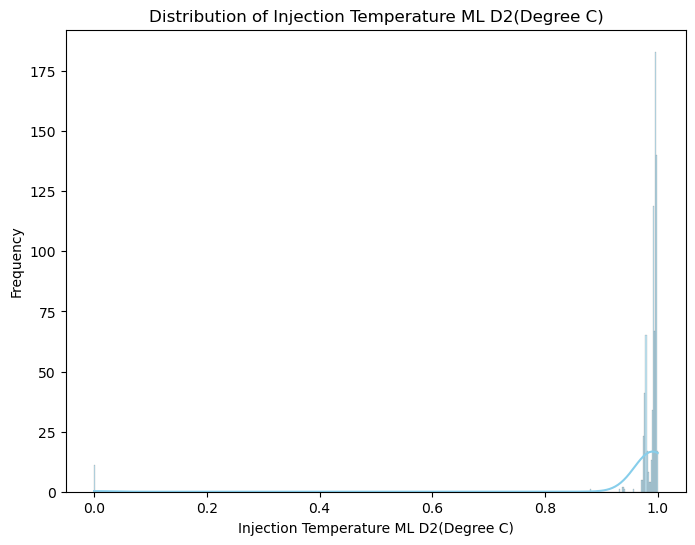

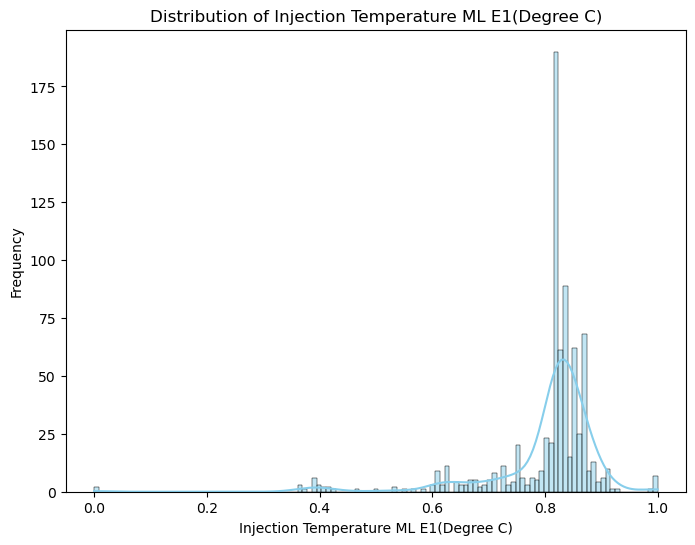

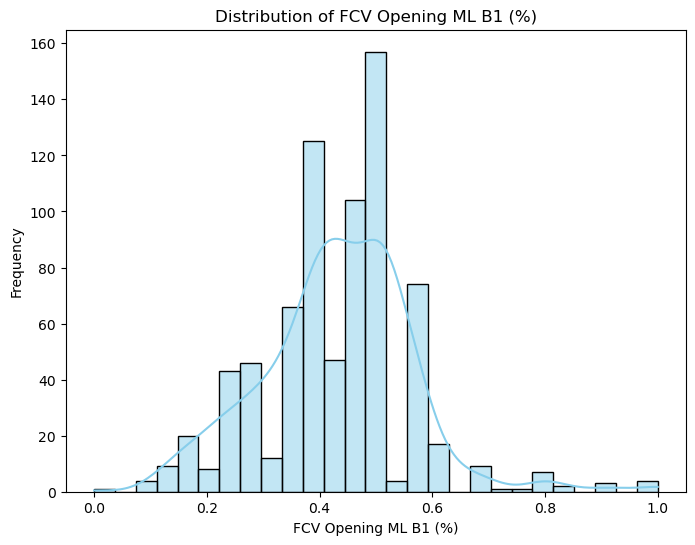

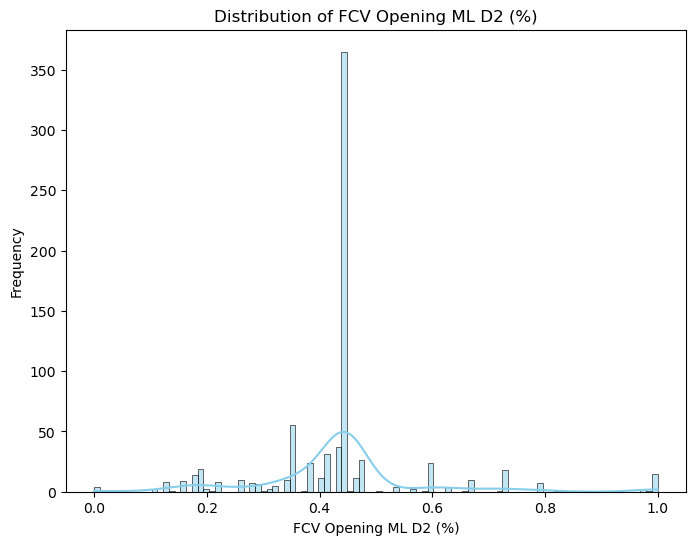

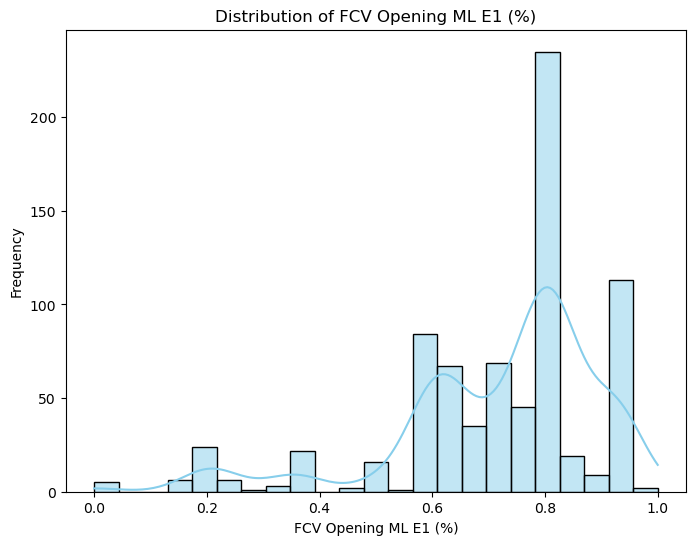

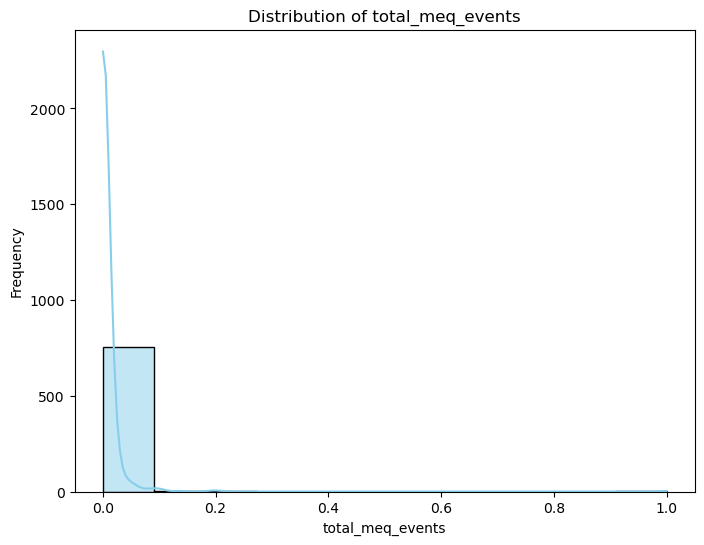

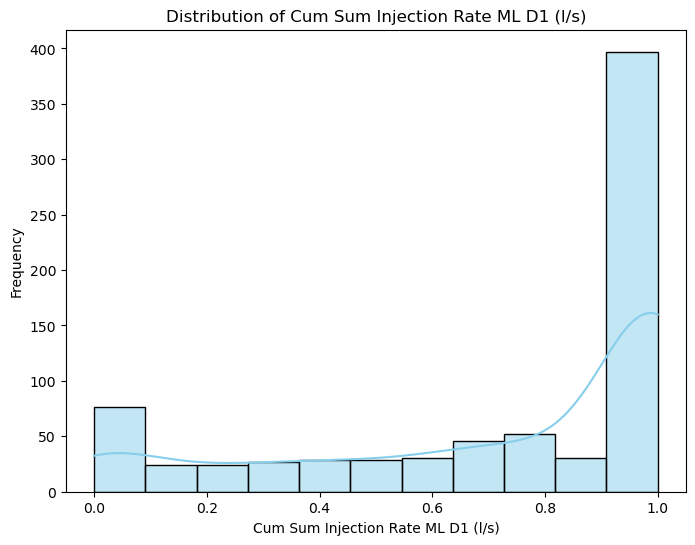

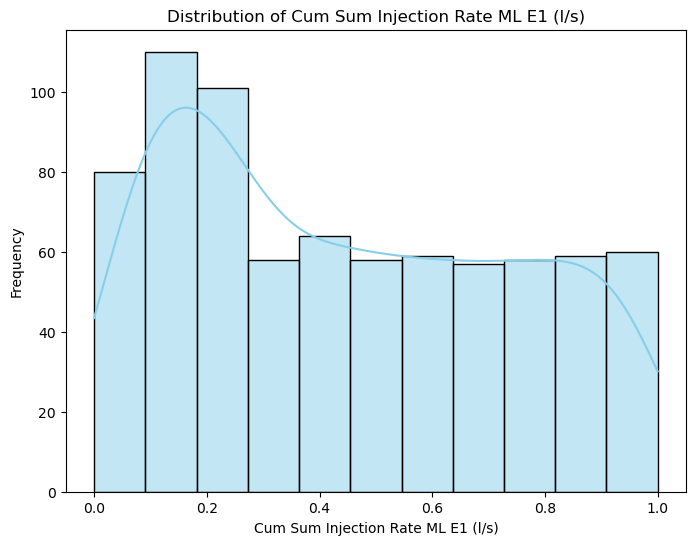

In [14]:
numeric_columns = scaled_df.select_dtypes(include=['float64', 'int64']).columns

for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(scaled_df[column], kde=True, color='skyblue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

After going through the MinMax scalling process, each numerical column in the dataset is now in the range of 0 - 1 and ready to enter the benchmarking model stage.

In [15]:
# Remove rows with missing values
scaled_df.dropna(inplace=True)

In [16]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Injection Rate ML B1 (l/s)             764 non-null    float64
 1   Injection Rate ML C1 (l/s)             764 non-null    float64
 2   Injection Rate ML D1 (l/s)             764 non-null    float64
 3   Injection Rate ML D2 (l/s)             764 non-null    float64
 4   Injection Rate ML E1 (l/s)             764 non-null    float64
 5   Injection Rate ML E2 (l/s)             764 non-null    float64
 6   WHP ML B1 (barg)                       764 non-null    float64
 7   WHP ML C1 (barg)                       764 non-null    float64
 8   WHP ML D1 (barg)                       764 non-null    float64
 9   WHP ML E2 (barg)                       764 non-null    float64
 10  Injection Temperature ML B1(Degree C)  764 non-null    float64
 11  Inject

In [17]:
scaled_df.columns

Index(['Injection Rate ML B1 (l/s)', 'Injection Rate ML C1 (l/s)',
       'Injection Rate ML D1 (l/s)', 'Injection Rate ML D2 (l/s)',
       'Injection Rate ML E1 (l/s)', 'Injection Rate ML E2 (l/s)',
       'WHP ML B1 (barg)', 'WHP ML C1 (barg)', 'WHP ML D1 (barg)',
       'WHP ML E2 (barg)', 'Injection Temperature ML B1(Degree C)',
       'Injection Temperature ML D2(Degree C)',
       'Injection Temperature ML E1(Degree C)', 'FCV Opening ML B1 (%)',
       'FCV Opening ML D2 (%)', 'FCV Opening ML E1 (%)', 'total_meq_events',
       'Cum Sum Injection Rate ML D1 (l/s)',
       'Cum Sum Injection Rate ML E1 (l/s)'],
      dtype='object')

# Machine Learning Modelling

The selection of models implemented in machine learning modeling is a model that is a tree-based model to extract feature importance information in order to identify factors that influence the occurences of induced seismicity. 

#### Data Splitting

In [18]:
x = scaled_df.drop(columns=['total_meq_events'])
y = scaled_df['total_meq_events']

In [19]:
x.describe()

,Injection Rate ML B1 (l/s),Injection Rate ML C1 (l/s),Injection Rate ML D1 (l/s),Injection Rate ML D2 (l/s),Injection Rate ML E1 (l/s),Injection Rate ML E2 (l/s),WHP ML B1 (barg),WHP ML C1 (barg),WHP ML D1 (barg),WHP ML E2 (barg),Injection Temperature ML B1(Degree C),Injection Temperature ML D2(Degree C),Injection Temperature ML E1(Degree C),FCV Opening ML B1 (%),FCV Opening ML D2 (%),FCV Opening ML E1 (%),Cum Sum Injection Rate ML D1 (l/s),Cum Sum Injection Rate ML E1 (l/s)
count,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000
mean,0.595199,0.164383,0.180888,0.577290,0.721165,0.106104,0.322798,0.740875,0.316604,0.158997,0.574432,0.975999,0.803145,0.431997,0.436098,0.716857,0.725557,0.447848
std,0.129849,0.089049,0.236616,0.156352,0.201614,0.196688,0.124514,0.333804,0.402504,0.305140,0.119345,0.118421,0.101948,0.135746,0.146403,0.185233,0.346042,0.294991
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.585832,0.150538,0.000000,0.465800,0.513952,0.000000,0.286466,0.821667,0.002430,0.009055,0.577236,0.987702,0.812155,0.342857,0.398754,0.616236,0.489692,0.182615
50%,0.620428,0.182796,0.000000,0.586000,0.823529,0.000000,0.339850,0.870000,0.014925,0.012992,0.593496,0.993750,0.823204,0.451429,0.445483,0.778598,0.939355,0.410396
75%,0.645140,0.215054,0.427235,0.710000,0.860294,0.168396,0.381203,0.918333,0.821677,0.035039,0.601626,0.995968,0.850829,0.514286,0.445483,0.815498,1.000000,0.705158
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
y.describe()

count    764.000000
mean       0.006324
std        0.039584
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: total_meq_events, dtype: float64

<Axes: >

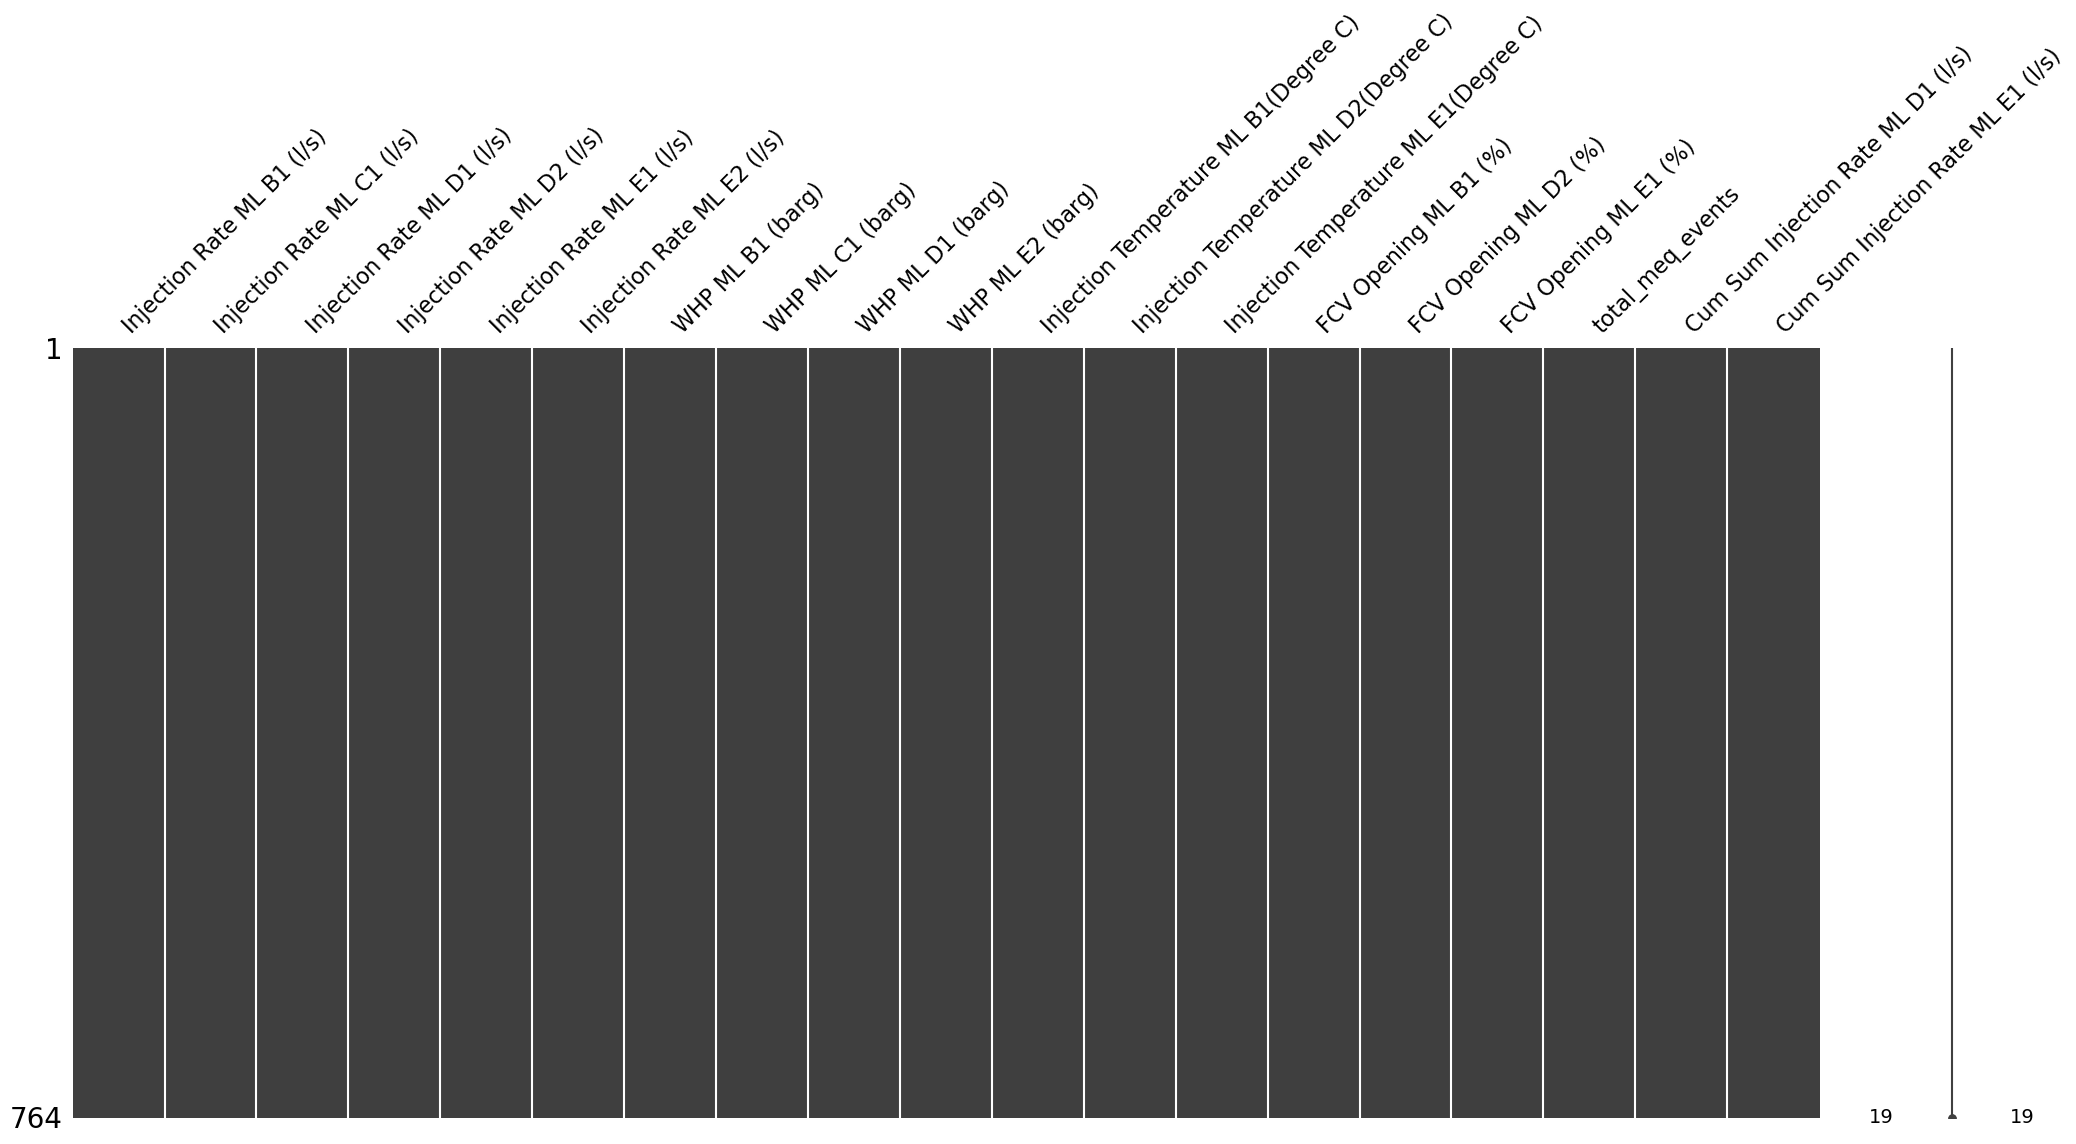

In [21]:
missingno.matrix(scaled_df)

In [22]:
# Splitting data training dan test dengan proporsi 85:15
x_train, x_test, y_train, y_test= train_test_split(
    x,
    y,  
    test_size=0.15,
    random_state=1)

In [23]:
x_train.isnull().sum()

Injection Rate ML B1 (l/s)               0
Injection Rate ML C1 (l/s)               0
Injection Rate ML D1 (l/s)               0
Injection Rate ML D2 (l/s)               0
Injection Rate ML E1 (l/s)               0
Injection Rate ML E2 (l/s)               0
WHP ML B1 (barg)                         0
WHP ML C1 (barg)                         0
WHP ML D1 (barg)                         0
WHP ML E2 (barg)                         0
Injection Temperature ML B1(Degree C)    0
Injection Temperature ML D2(Degree C)    0
Injection Temperature ML E1(Degree C)    0
FCV Opening ML B1 (%)                    0
FCV Opening ML D2 (%)                    0
FCV Opening ML E1 (%)                    0
Cum Sum Injection Rate ML D1 (l/s)       0
Cum Sum Injection Rate ML E1 (l/s)       0
dtype: int64

In [24]:
x_test.isnull().sum()

Injection Rate ML B1 (l/s)               0
Injection Rate ML C1 (l/s)               0
Injection Rate ML D1 (l/s)               0
Injection Rate ML D2 (l/s)               0
Injection Rate ML E1 (l/s)               0
Injection Rate ML E2 (l/s)               0
WHP ML B1 (barg)                         0
WHP ML C1 (barg)                         0
WHP ML D1 (barg)                         0
WHP ML E2 (barg)                         0
Injection Temperature ML B1(Degree C)    0
Injection Temperature ML D2(Degree C)    0
Injection Temperature ML E1(Degree C)    0
FCV Opening ML B1 (%)                    0
FCV Opening ML D2 (%)                    0
FCV Opening ML E1 (%)                    0
Cum Sum Injection Rate ML D1 (l/s)       0
Cum Sum Injection Rate ML E1 (l/s)       0
dtype: int64

In [25]:
y_train.isnull().sum()

0

In [26]:
y_test.isnull().sum()

0

In [27]:
print(x_train.shape)
print(x_test.shape)

(649, 18)
(115, 18)


In [28]:
print(y_train.shape)
print(y_test.shape)

(649,)
(115,)


## Model Benchmarking

The machine learning modelling methods for regression including linear regression, decision tree, random forest, and extreme gradient boosting (XGBoost), also we add two regularization techniques such lasso and ridge to be compared as well. 

In [29]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Decision Tree': DecisionTreeRegressor(random_state=1),
    'Random Forest': RandomForestRegressor(random_state=1),
    'XGBoost': XGBRegressor(random_state=1)
}

In [30]:
from sklearn.metrics import mean_absolute_error

model = []
model.append(('Linear Regression', LinearRegression()))
model.append(('Ridge Regression',Ridge()))
model.append(('Lasso Regression',Lasso()))
model.append(('Decision Tree Regressor', DecisionTreeRegressor(random_state=1)))
model.append(('Random Forest Regressor', RandomForestRegressor(random_state=1)))
model.append(('Extreme Gradient Boosting (XGB) Regressor', XGBRegressor(random_state=1)))

result_rmse = []
result_mae = []
names = []

for name, model in model:
    
    cross_val = KFold(n_splits=5, shuffle=True, random_state=1)
    
    pipe_model = Pipeline([('model', model)])
    
    cv_result_rmse = cross_val_score(pipe_model, x_train, y_train, cv=cross_val, scoring='neg_root_mean_squared_error')
    cv_result_mae = cross_val_score(pipe_model, x_train, y_train, cv=cross_val, scoring='neg_mean_absolute_error')
    
    result_rmse.append(cv_result_rmse)
    result_mae.append(cv_result_mae)
    names.append(name)
    
    print(name)
    print('RMSE:', -cv_result_rmse.mean())
    print('MAE:', -cv_result_mae.mean())
    print("\n")


Linear Regression
RMSE: 0.031105638168111693
MAE: 0.011335922261254723


Ridge Regression
RMSE: 0.030883006340988145
MAE: 0.011054322535420057


Lasso Regression
RMSE: 0.03052399554921257
MAE: 0.01084037834039722


Decision Tree Regressor
RMSE: 0.07284954540337947
MAE: 0.016868002653213


Random Forest Regressor
RMSE: 0.04313216047425644
MAE: 0.014115930668060273


Extreme Gradient Boosting (XGB) Regressor
RMSE: 0.05040612960784181
MAE: 0.013507139747027237




From the table above, we can see that the **trained dataset with Lasso model has the lowest average RMSE and MAE**, meaning that this model has the smallest deviation from the actual value of the target. We then select the Lasso model for hyperparameter tuning model optimization.

## Hyperparameter Tuning

In the hyperparameter tuning stage, the best parameters for the selected model are searched using both randomized and grid search methods. Random search is a faster approach for hyperparameter tuning because it samples a subset of hyperparameters from a specified distribution, whereas grid search tries every combination of hyperparameters in the parameter grid.

For the Lasso model, the four hyperparameters being tuned are:

* Alpha: The alpha hyperparameter controls the strength of regularization in the Lasso model. Higher alpha values result in stronger regularization, which tends to produce sparser coefficient vectors. The specified range of values is [1000, 100, 10, 1, 0.1, 0.001, 0.0001], covering a wide range from very large to very small values.

* Fit Intercept: This hyperparameter determines whether to add an intercept to the model (also known as the y-axis intercept). If set to True, an intercept will be included in the model. If set to False, the model is expected to pass through the origin (0,0). In grid search, this hyperparameter has two possible values: True and False.

* Max Iter: This is the maximum number of iterations that the optimization algorithm will perform when finding the coefficients. A higher number of iterations may increase the likelihood of convergence but also increases training time. The specified range of values is [100, 1000, 10000], providing different choices for the number of iterations.

* Positive: This hyperparameter determines whether the resulting coefficients should be constrained to be positive or not. If set to True, only positive coefficients are allowed. If set to False, coefficients can be positive or negative. In grid search, this hyperparameter has two possible values: True and False.

By performing hyperparameter tuning on combinations of these values, we can find the optimal combination to improve the Lasso model's performance in predicting data.

In [31]:
# Define Lasso model
model = Lasso()

# Define parameter grid
param_ = {'alpha': [1000, 100, 10, 1, 0.1, 0.001, 0.0001], 'fit_intercept': [True, False],
          'max_iter': [100, 1000, 10000], 'positive': [True, False]}


In [32]:
# Randomized search CV
random_search = RandomizedSearchCV(model, param_distributions=param_, n_iter=5, cv=5, scoring='neg_mean_squared_error', random_state=1)

# Fit the model
random_search.fit(x_train, y_train)

# Predict before tuning
y_pred_before = model.fit(x_train, y_train).predict(x_test)
rmse_before = mean_squared_error(y_test, y_pred_before, squared=False)
mae_before = mean_absolute_error(y_test, y_pred_before)

# Predict after tuning
y_pred_after_rs = random_search.best_estimator_.predict(x_test)
rmse_after_rs = mean_squared_error(y_test, y_pred_after_rs, squared=False)
mae_after_rs = mean_absolute_error(y_test, y_pred_after_rs)

# Print results
print("RMSE Before Tuning:", rmse_before)
print("MAE Before Tuning:", mae_before)
print("\n")
print("RMSE After Random Search Tuning:", rmse_after_rs)
print("MAE After Random Search Tuning:", mae_after_rs)
print("\n")
print("Best Parameters:", random_search.best_params_)

RMSE Before Tuning: 0.009564130568750093
MAE Before Tuning: 0.0077931325710216695


RMSE After Random Search Tuning: 0.010165222064156989
MAE After Random Search Tuning: 0.00801819885594166


Best Parameters: {'positive': False, 'max_iter': 10000, 'fit_intercept': False, 'alpha': 0.0001}


In [33]:
# Grid search CV
grid_search = GridSearchCV(model, param_grid=param_, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(x_train, y_train)

# Predict before tuning
y_pred_before = model.fit(x_train, y_train).predict(x_test)
rmse_before = mean_squared_error(y_test, y_pred_before, squared=False)
mae_before = mean_absolute_error(y_test, y_pred_before)

# Predict after tuning
y_pred_after_gs = grid_search.best_estimator_.predict(x_test)
rmse_after_gs = mean_squared_error(y_test, y_pred_after_gs, squared=False)
mae_after_gs = mean_absolute_error(y_test, y_pred_after_gs)

# Print results
print("RMSE Before Tuning:", rmse_before)
print("MAE Before Tuning:", mae_before)
print("\n")
print("RMSE After Grid Search Tuning:", rmse_after_gs)
print("MAE After Grid Search Tuning:", mae_after_gs)
print("\n")
print("Best Parameters:", grid_search.best_params_)



RMSE Before Tuning: 0.009564130568750093
MAE Before Tuning: 0.0077931325710216695


RMSE After Grid Search Tuning: 0.0101617363015689
MAE After Grid Search Tuning: 0.007869257081364548


Best Parameters: {'alpha': 0.0001, 'fit_intercept': True, 'max_iter': 100, 'positive': True}


It turns out that model optimization through hyperparameter tuning does not cause the RMSE and MAE metrics to decrease, meaning that the tuning model results are not that accurate compared to the model before tuning. However, in order to extract the influential factors in feature importance analysis (in the case of lasso model is namely feature coefficient) we will fill the hyperparameters using grid search's best parameters as its MAE close to the value before tuning.

## Feature Importance Analysis

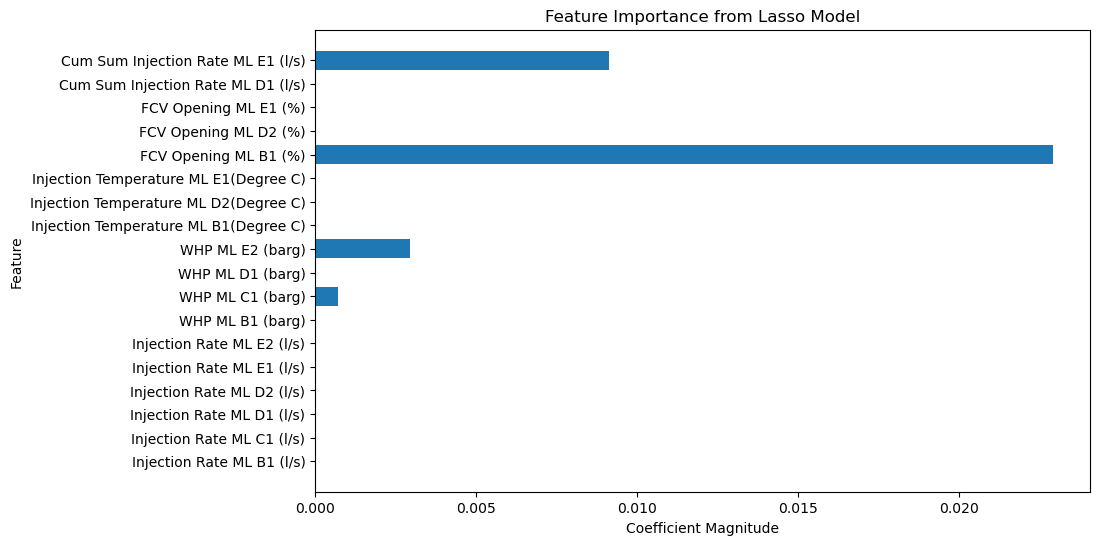

In [34]:
lasso_model = Lasso(alpha=grid_search.best_params_['alpha'], 
                    fit_intercept=grid_search.best_params_['fit_intercept'], 
                    max_iter=grid_search.best_params_['max_iter'], 
                    positive=grid_search.best_params_['positive'])

lasso_model.fit(x_train, y_train)

# Get feature coefficients
feature_coefficients = lasso_model.coef_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(scaled_df.drop(columns=['total_meq_events']).columns, feature_coefficients)
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance from Lasso Model')
plt.show()

Unexpectedly, flow control valves in well B1 have the greatest impact on induced seismicity, more so than the other operational reservoir parameters associated with hydraulics, like injection rate or wellhead pressure, or linked with thermals, like injection temperature. In this dataset, both injection rate and injection temperature had no effect on the generation of seismicity. However, the cumulative injection rate of the E1 brine well is one of the factors influencing the occurrence of micro-earthquakes in this geothermal field, and is the second dominant reservoir operating parameter related to hydraulics that can be a trigger for seismicity. In addition, it appears that wellhead pressure at wells E2 and C1 also minorly affects the occurrence of microearthquakes.

The prominence of flow control valves (FCVs) as the top-ranked feature of importance in driving induced seismicity in the machine learning model evaluation may be attributed to several factors:

1. Flow Regulation; FCVs play a critical role in regulating the flow of fluids within a reservoir or production system. Changes in fluid flow dynamics or variations in flow rates controlled by FCVs can lead to stress changes, induce changes in pressure distribution and fluid movement within the reservoir, potentially influencing the subsurface stress conditions and triggering seismic events.
2. Reservoir Conditions; The behavior of FCVs may be influenced by reservoir properties, such as reservoir pressure, fluid composition, and geological structures. Changes in these conditions can affect the operation of FCVs and, consequently, their impact on induced seismicity.

# Business Implementation

Effective management of reservoir operating parameters, particularly FCV and cumulative injection rate, can mitigate the risk of seismic events, protect infrastructure, minimize operational downtime and ultimately protect investments in reservoir development projects. In addition, prioritizing FCV optimisation aligns with broader sustainability objectives by ensuring safe and responsible geothermal resource extraction practices.

# Conclusion

**1. Machine Learning Model**
- The best machine learning model used was Lasso Model without hyperparameter tuning, with a RMSE and MAE equals 0.9% and 0.7%. 

**2. Feature Importance**
- Feature importance of the optimised lasso model showed that the seismicity rate was sensitive to the opening of the flow control valve in brine well B1 that might be governed wheter by flow regulation or resevoir condition, and the cumulative injection rate in brine well E1.
- However, as injectivity is dependent on the temperature of the injected water in all wells, the implementation of machine learning modelling for this geothermal dataset does not demonstrate that thermal effects drive induced seismicity.

# Recommendation

1. Physics-based modelling such Thermo-Hydro-Mechanical (THM) modelling should be carried out as well and developed to establish the link between induced seismicity and fluid reinjection, and will answer whether it is under the combined effects of pore pressure change, poroelastic stress, thermoelastic stress and fluid injection, or transient cooling induced permeability enhancement.

2. Machine learning requires a large data set for training and validation. Inadequate training and validation can result in a less representative model and therefore less reliable prediction. Where possible, operational data from the reservoir and the total daily microseismic data should be more abundant.